In [26]:
from gensim.models import Word2Vec,FastText
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from tensorflow import keras
import re
from nltk.stem import WordNetLemmatizer
from word2number import w2n



from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding,LSTM,Dense,Input,Bidirectional,Attention,Concatenate,TimeDistributed

pd.set_option("display.max_columns", None)
np.random.seed(42)
tf.random.set_seed(42)


In [19]:
df_dev = pd.read_json("dataset/PIZZA_dev.json", lines=True,)
x_dev = df_dev["dev.SRC"]
y_dev = df_dev["dev.TOP"]   

In [20]:
main_train = pd.read_json("dataset/PIZZA_train.json", lines=True,)
df_dev = pd.read_json("dataset/PIZZA_dev.json", lines=True,)

In [21]:
df_train = main_train.sample(10000)

In [81]:
CONTRACTIONS = {
    "n't": "not",
    "'s": "is",
    "'re": "are",
    "'m": "am",
    "'ll": "will",
    "'ve": "have",
    "'d": "would",
    "'em": "them",
    "'all": "all",
    "'cause": "because",
    "'clock": "oclock",
    "'tis": "it is",
    "'twas": "it was",
    "'tween": "between",
    "'twere": "it were",
    "'twould": "it would",
    "'twixt": "betwixt",
    "'twill": "it will",
    "'til": "until",
    "'bout": "about",
    "'cept": "except",
    "'cos": "because",
    "'fore": "before",
    "'round": "around",
    "'n'": "and",
    "'neath": "beneath",
    "'nother": "another",
    "'nuff": "enough",
}
negation_words = {
    "no",
    "not",
    "none",
    "never",
    "without",
    "avoid",
    "neither",
    "nor",
    "hate",
    "hold",
}
pizza = {"pizza", "pizzas", "pie", "pies"}

stop_negation_words = {"and", "but"}
stop_words = set(stopwords.words("english"))
stop_words = stop_words - negation_words - stop_negation_words - {'all' , 'a','an'}
stop_words.update({"would", "like", "get", "want", "order"})
stop_words.update(pizza)

lemmatizer = WordNetLemmatizer()  # WordNet Lemmatizer


In [82]:
def expnad_abb2(text):

    pattern = re.compile(
        r"(" + "|".join(re.escape(key) for key in CONTRACTIONS.keys()) + r")"
    )
    expanded_text = pattern.sub(lambda x: " " + CONTRACTIONS[x.group()], text)
    return expanded_text


In [24]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [25]:
relation_tags = {
    'O':0,
    'B-Pizza':1, 'I-Pizza':2,
    'B-Drink':3, 'I-Drink':4,
}

In [83]:
pizza_order_regex = re.compile(r'\(PIZZAORDER\b\s*((?:[^()]*|\((?:[^()]*|\([^()]*\))*\))*)\)')
drink_order_regex = re.compile(r'\(DRINKORDER\b\s*((?:[^()]*|\((?:[^()]*|\([^()]*\))*\))*)\)')

clean_regex = re.compile(r'[A-Z]+_?[A-Z]*|\(|\)')
# clean_regex = re.compile(r'\(NUMBER |\(SIZE |\(TOPPING |\(COMPLEX_TOPPING |\(NOT |\(STYLE |\(DRINKTYPE |\(VOLUME |\(CONTAINERTYPE |\s+\)\s+')

In [8]:

def standardize_numbers(text):
    text = text.split()
    for i,w in enumerate(text):
        try:
            text[i] = str(w2n.word_to_num(w))
        except:
            if text[i] == 'a' or text[i] == 'an':
                text[i] = '1'
            else:
                text[i] = w
    return " ".join(text)


In [27]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text] 
    return " ".join(text)

In [13]:
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: expnad_abb2(x))
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: remove_stopwords(x))
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: standardize_numbers(x))
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: lemma(x))

In [84]:
def pizza_order_parser(src,top):
    labels = ['O' for i in range(len(src.split()))]
    src = src.split()
    pizza_orders = pizza_order_regex.findall(top)
    pizza_orders = [clean_regex.sub("", order) for order in pizza_orders]
    pizza_orders = [order.split() for order in pizza_orders]
    # pizza_orders = [re.split(r'\s+|_', order) for order in pizza_orders]
    # pizza_orders = [[word.lower() for word in order if len(word) > 0] for order in pizza_orders]
    for order in pizza_orders:
        # order = [word.lower() for word in order]
        try:
            start_index = src.index(order[0])
        except:
            order = order[1:]
            start_index = src.index(order[0])

        while labels[start_index] != 'O':
            # try:
            start_index = src.index(order[0],start_index+1)
            # except:
                # break
        labels[start_index] = "B-Pizza"
        for word in order[1:]:
            try:
                labels[src.index(word, start_index + 1)] = "I-Pizza"
            except: 
                continue
        
    return " ".join(labels)   

# src = x_dev[0]
# # src = expnad_abb2(src)
# # src = remove_stopwords(src)
# # src = standardize_numbers(src)
# # src = lemma(src)
# print(src)
# top = y_dev[0]
# 
# print(pizza_order_parser(src,top))

In [85]:
def drink_order_parser(src,top,labels):
    # labels = ['O' for i in range(len(src.split()))]
    labels = labels.split()
    src = src.split()
    drink_orders = drink_order_regex.findall(top)
    drink_orders = [clean_regex.sub("", order) for order in drink_orders]
    drink_orders = [order.split() for order in drink_orders]
    # drink_orders = [re.split(r'\s+|_', order) for order in drink_orders]
    # drink_orders = [[word.lower() for word in order if len(word) > 0] for order in drink_orders]
    for order in drink_orders:
        # order = [word.lower() for word in order]
        try:
            start_index = src.index(order[0])
        except:
            order = order[1:]
            start_index = src.index(order[0])
        while labels[start_index] != 'O':
            try:
                start_index = src.index(order[0],start_index+1)
            except:
                break
        labels[start_index] = "B-Drink"
        for word in order[1:]:
            try:
                labels[src.index(lemma(word), start_index + 1)] = "I-Drink"
            except:
                continue
        
    return " ".join(labels)

# src = "two 20 fl ounce diet sprites in cans and four 500-ml coke zeroes"
# src = expnad_abb2(src)
# src = remove_stopwords(src)
# src = standardize_numbers(src)
# src = lemma(src)
# print(src)
# top = "order (PIZZAORDER ) (SIZE medium ) pizzas with (TOPPING and (TOPPING black olives ) ) and two ) (SIZE"
# labels = pizza_order_parser(src,top)

# drink_order_parser(src,top,labels)
   

In [86]:
df_train['train.LABEL'] = df_train.apply(lambda x: pizza_order_parser(x['train.SRC'], x['train.TOP']), axis=1)

In [87]:
df_train['train.LABEL'] = df_train.apply(lambda x: drink_order_parser(x['train.SRC'], x['train.TOP'],x['train.LABEL']), axis=1)

In [88]:
def expand(text,labels):
    labels = labels.split()
    text = text.split()
    new_text = text.copy()
    for i in range(len(text)):
       exp =  expnad_abb2(text[i])
       if exp != text[i]:
            new_text[i]= exp
            labels.insert(i,labels[i])
    return " ".join(new_text) , " ".join(labels)


In [89]:
def remove_stopwords_with_labels(text,labels):
    labels = labels.split()
    new_labels = []
    text = text.split()
    new_text = []
    for i in range(len(text)):
       if text[i].lower() not in stop_words:
            new_text.append(text[i])
            new_labels.append(labels[i])
            # i = 
    return " ".join(new_text) , " ".join(new_labels)



In [90]:
x_train = df_train['train.SRC']
y_train = df_train['train.LABEL']

In [91]:
for i,x in enumerate(x_train):
    x_train.iloc[i],y_train.iloc[i] = expand(x,y_train.iloc[i])
    x_train.iloc[i],y_train.iloc[i]= remove_stopwords_with_labels(x_train.iloc[i],y_train.iloc[i])


In [93]:
fast_text_model = FastText(sentences=x_train.apply(lambda x : x.split()), vector_size=50, window=5, min_count=1, workers=4, sg=1,epochs=150)

In [94]:
# Tokenize the sentences
input_tokinezer = Tokenizer(oov_token = "<OOV>")
input_tokinezer.fit_on_texts(x_train)
x_train = input_tokinezer.texts_to_sequences(x_train)
word_index = input_tokinezer.word_index

# Pad sequences for uniform input size
max_length = max([len(seq) for seq in x_train])  # Padding to the length of the longest sentence
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')

# Convert labels to integer format (one per word)
y_train = [y.split() for y in y_train]
y_train = [[relation_tags[label] for label in seq] for seq in y_train]
y_train = pad_sequences(y_train, maxlen=max_length, padding='post')  # Padding labels

# Prepare word embeddings using FastText
embedding_dim = fast_text_model.wv.vector_size  # Dimension of Word2Vec vectors

# Initialize a matrix to store word vectors
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Fill the embedding matrix with FastText word vectors
for word, idx in word_index.items():
    if word in fast_text_model.wv.key_to_index.keys():
        # print("found" , word)
        embedding_matrix[idx] = fast_text_model.wv[word]
    else:
        print("not found" , word)
        embedding_matrix[idx] = np.random.uniform(-0.01, 0.01, embedding_dim)


not found <OOV>


In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model


In [95]:
# Define the BiLSTM model
input = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)(input)

lstm = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
dropout = Dropout(0.1)(lstm)

# Dense layer for sequence labeling (softmax activation)
output = Dense(len(relation_tags), activation='softmax')(dropout)

# Build and compile the model
model_relations = Model(inputs=input, outputs=output)
model_relations.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_relations.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 22, 50)         │        14,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 22, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22, 5)          │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,681 (776.10 KB)

 Trainable params: 184,581 (721.02 KB)

 Non-trainable params: 14,100 (55.08 KB)

In [96]:
# Train the model
hist = model_relations.fit(x_train, y_train, batch_size=16, epochs=10, validation_split=0.1)


Epoch 1/10


563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9023 - loss: 0.3237 - val_accuracy: 0.9857 - val_loss: 0.0498
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9861 - loss: 0.0470 - val_accuracy: 0.9880 - val_loss: 0.0361
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9883 - loss: 0.0351 - val_accuracy: 0.9889 - val_loss: 0.0301
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9895 - loss: 0.0297 - val_accuracy: 0.9892 - val_loss: 0.0276
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9898 - loss: 0.0270 - val_accuracy: 0.9899 - val_loss: 0.0260
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9899 - loss: 0.0253 - val_accuracy: 0.9895 - val_loss: 0.0240
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9905 - loss: 0.0236 - val_accuracy: 0.9893 - val_loss: 0.0242
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9904 - loss: 0.0227 - val_accuracy: 0.99

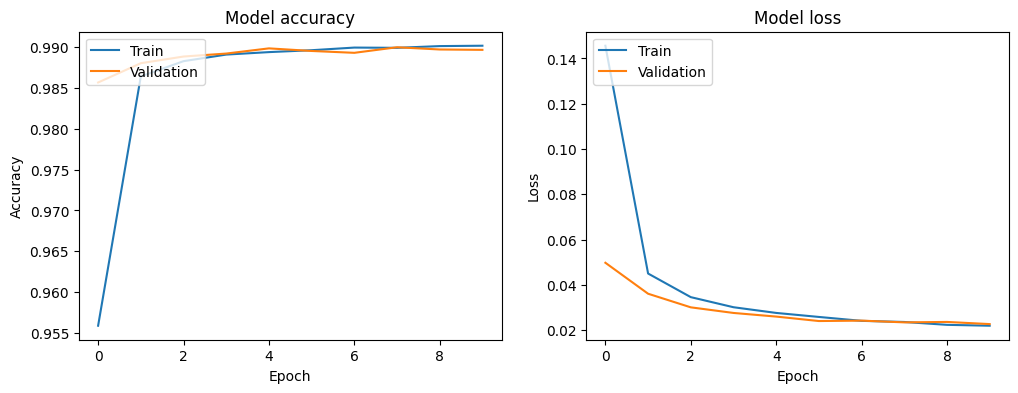

In [97]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [49]:
x_test = "i want to order two medium pizzas with sausage and black olives and two medium pizzas with pepperoni and extra cheese and three large pizzas with pepperoni and sausage"

In [51]:
x_test = expnad_abb2(x_test)
x_test = remove_stopwords(x_test)
x_test

'two medium sausage and black olives and two medium pepperoni and extra cheese and three large pepperoni and sausage'

In [52]:
x_test = input_tokinezer.texts_to_sequences([x_test])


In [53]:
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

In [54]:
pred = model_relations.predict(x_test)
pred = np.argmax(pred, axis=-1)

pred = [list(relation_tags.keys())[list(relation_tags.values()).index(i)] for i in pred[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


In [55]:
x_test = input_tokinezer.sequences_to_texts(x_test)
x_test

['two medium sausage and black olives and two medium pepperoni and extra cheese and three large pepperoni and sausage <OOV> <OOV> <OOV>']

In [56]:
print(pred)

['B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'O', 'O']


# Second Model

In [30]:
from keras.models import Sequential

In [31]:
tags = [
    'O',
    'B-DRINKORDER', 'I-DRINKORDER',
    'B-PIZZAORDER', 'I-PIZZAORDER',
    'B-NUMBER', 'I-NUMBER',
    'B-DRINKTYPE', 'I-DRINKTYPE',
    'B-VOLUME', 'I-VOLUME',
    'B-TOPPING', 'I-TOPPING',
    'B-SIZE', 'I-SIZE',
    'B-QUANTITY', 'I-QUANTITY',
    'B-STYLE', 'I-STYLE',
    'B-CONTAINER', 'I-CONTAINER',
    'B-NOT-TOPPING', 'I-NOT-TOPPING',
    'B-NOT-STYLE' , 'I-NOT-STYLE'
]

In [32]:
toppings_regex = re.compile(r'(?<=\(TOPPING\s)[^)]*(?=\s)')
number_regex = re.compile(r'(?<=\(NUMBER\s)[^)]*(?=\s)')
size_regex = re.compile(r'(?<=\(SIZE\s)[^)]*(?=\s)')
quantity_regex = re.compile(r'(?<=\(QUANTITY\s)[^)]*(?=\s)')
style_regex = re.compile(r'(?<=\(STYLE\s)[^)]*(?=\s)')
drink_type_regex = re.compile(r'(?<=\(DRINKTYPE\s)[^)]*(?=\s)')
volume_regex = re.compile(r'(?<=\(VOLUME\s)[^)]*(?=\s)')
container_type_regex = re.compile(r'(?<=\(CONTAINERTYPE\s)[^)]*(?=\s)')   

In [33]:
sizes = set()
toppings = set()
numbers = set()
quantities = set()
styles = set()
drink_types = set()
container_types = set()
volumes = set()


In [34]:
sizes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: size_regex.findall(x)) for item in sublist])
toppings.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: toppings_regex.findall(x)) for item in sublist])
numbers.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: number_regex.findall(x)) for item in sublist])
quantities.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: quantity_regex.findall(x)) for item in sublist])
styles.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: style_regex.findall(x)) for item in sublist])
drink_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: drink_type_regex.findall(x)) for item in sublist])
container_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: container_type_regex.findall(x)) for item in sublist])
volumes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: volume_regex.findall(x)) for item in sublist])


In [35]:
def clean_text(text):
    text = re.sub(r"[^\w']", " ", text)  # Remove non-word characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

In [36]:
sizes = list(sizes)
toppings = list(toppings)
numbers = list(numbers)
quantities = list(quantities)
styles = list(styles)
drink_types = list(drink_types)
container_types = list(container_types)
volumes = list(volumes)

In [37]:
sizes = [lemma(size) for size in sizes]
toppings = [lemma(topping) for topping in toppings]
numbers = [lemma(number) for number in numbers]
quantities = [lemma(quantity) for quantity in quantities]
styles = [lemma(style) for style in styles]
drink_types = [lemma(drink_type) for drink_type in drink_types]
container_types = [lemma(container_type) for container_type in container_types]
volumes = [lemma(volume) for volume in volumes]


In [38]:
b_toppings = set()
i_toppings = set()

for topping in toppings:
    topping = topping.split()
    b_toppings.add(topping[0])
    i_toppings.update(topping[1:])

b_toppings = list(b_toppings)
i_toppings = list(i_toppings)


In [39]:
b_styles = set()
i_styles = set()

for style in styles:
    style = style.split()
    style = [word for word in style if word not in {"and", "with",'the'}]
    b_styles.add(style[0])
    i_styles.update(style[1:])

b_styles = list(b_styles)
i_styles = list(i_styles)

In [40]:
b_sizes = set()
i_sizes = set()

for size in sizes:
    size = size.split()
    size = [word for word in size if word not in {'-'}]
    b_sizes.add(size[0])
    i_sizes.update(size[1:])

b_sizes = list(b_sizes)
i_sizes = list(i_sizes)


In [41]:
b_drink_types = set()
i_drink_types = set()

for drink_type in drink_types:
    drink_type = drink_type.split()
    b_drink_types.add(drink_type[0])
    i_drink_types.update(drink_type[1:])

b_drink_types = list(b_drink_types)
i_drink_types = list(i_drink_types)


In [42]:
i_volume = set()

for volume in volumes:
    volume = volume.split('-') 
    if len(volume) == 1:
        volume = volume[0].split()
    
    i_volume.add(volume[1])
    if len(volume) > 2:
        i_volume.update(volume[2:])

i_volume = list(i_volume)
    


In [43]:
def manual_annotation(text):
    # Break down the text and assign tags manually
    tokens = text.lower().split()
    labels = ['O'] * len(tokens)
    
    negation = False
    
    
    # Identify numbers
    for i, token in enumerate(tokens):
        try:
            token = str(w2n.word_to_num(token))
            labels[i] = 'B-NUMBER'
        except:
            if token == 'a' or token == 'an':
                labels[i] = 'B-NUMBER'
                if token.isdigit():
                    labels[i] = 'B-NUMBER'
    
    # Identify volumes
    for i, token in enumerate(tokens):
        if token in i_volume:
            labels[i-1] = 'B-VOLUME'
            labels[i] = 'I-VOLUME'

    # Identify styles
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        if token in b_styles:
            labels[i] = 'B-STYLE' if not negation else 'B-NOT-STYLE'
            if i+1 < len(tokens) and tokens[i+1] in i_styles:
                labels[i+1] = 'I-STYLE' if not negation else 'I-NOT-STYLE'
            negation = False
    
    # Identify toppings
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        elif token in b_toppings:
            labels[i] = 'B-TOPPING' if not negation else 'B-NOT-TOPPING'
            negation = False

    for i, token in enumerate(tokens):
        if token in i_toppings :
            labels[i] = 'I-NOT-TOPPING' if labels[i-1] == 'B-NOT-TOPPING' else 'I-TOPPING' if labels[i-1] == 'B-TOPPING' else labels[i]
    
    # Identify sizes
    for i, token in enumerate(tokens):
        if token in ['sized', 'size']:
            labels[i] = 'I-SIZE'
            labels[i-1] = 'B-SIZE'
        if token in b_sizes:
            labels[i] = 'B-SIZE'

        # Identify drink orders
    for i, token in enumerate(tokens):
        if token in b_drink_types:
            labels[i] = 'B-DRINKTYPE'
            if i+1 < len(tokens) and tokens[i+1] in i_drink_types:
                labels[i+1] = 'I-DRINKTYPE'

    # Identify quantities
    for i, token in enumerate(tokens):
        if token in quantities:
            labels[i] = 'B-QUANTITY'
            if i+1 < len(tokens) and tokens[i+1] in quantities:
                labels[i+1] = 'I-QUANTITY'

    # Identify containers
    for i, token in enumerate(tokens):
        if token in container_types:
            labels[i] = 'B-CONTAINER'
            if i+1 < len(tokens) and tokens[i+1] in container_types:
                labels[i+1] = 'I-CONTAINER'
    
   

                
    return labels

# # Example usage
# text = "five medium pizzas with tomato and ham with no cheese"
# # text = tokenize_adj_noun(text)
# labels = manual_annotation(text)
# print(list(zip(text.split(), labels)))


In [44]:
def generate_training_data(texts):
    labeled_texts = []
    labeled_labels = []
    
    for text in texts:
        # text = tokenize_adj_noun(text)
        labels = manual_annotation(text)
        labeled_texts.append(text)
        labeled_labels.append(" ".join(labels))

    
    return labeled_texts, labeled_labels

In [71]:
X_train, y_train = generate_training_data(df_train['train.SRC'].apply(clean_text).apply(lemma))

In [72]:
for i in range(len(X_train)):
    X_train[i],y_train[i] = expand(X_train[i],y_train[i])
    X_train[i],y_train[i]= remove_stopwords_with_labels(X_train[i],y_train[i])

In [54]:
# fast_text_model_2 = FastText(sentences= [X_train], vector_size=50, window=5, min_count=1, workers=4, sg=1,epochs=150)

In [51]:
# fast_text_model_2.wv.key_to_index.keys()

dict_keys([' ', 'e', 'a', 'i', 't', 'n', 'r', 'p', 'o', 'd', 'h', 'l', 'z', 's', 'c', 'w', 'u', 'm', 'f', 'g', 'b', 'k', 'v', 'y', "'", '0', '2', 'x', '5', '1', 'j', '6', '8', 'q', '7', '3', '4', '9'])

In [73]:
input_tokinezer_2 = Tokenizer(oov_token = "<OOV>")
input_tokinezer_2.fit_on_texts(X_train)
X_train = input_tokinezer_2.texts_to_sequences(X_train)

In [74]:
y_train = [y.split() for y in y_train]
y_train = [[tags.index(tag) for tag in y] for y in y_train]

In [75]:
max_len = max([len(x) for x in X_train])

In [76]:
y_train = pad_sequences(y_train,max_len, padding='post')
X_train = pad_sequences(X_train,max_len, padding='post')

In [ ]:
# word_index_2 = input_tokinezer_2.word_index
# # Prepare word embeddings using FastText
# embedding_dim_2 = fast_text_model_2.wv.vector_size  # Dimension of Word2Vec vectors

# # Initialize a matrix to store word vectors
# embedding_matrix_2 = np.zeros((len(word_index_2) + 1, embedding_dim_2))

# # Fill the embedding matrix with FastText word vectors
# for word, idx in word_index_2.items():
#     if word in fast_text_model_2.wv.key_to_index.keys():
#         # print("found" , word)
#         embedding_matrix_2[idx] = fast_text_model_2.wv[word]
#     else:
#         print("not found" , word)
#         embedding_matrix_2[idx] = np.random.uniform(-0.01, 0.01, embedding_dim_2)

In [64]:
from tensorflow.keras.layers import Embedding,LSTM,Dense,Input,Bidirectional,Attention,Concatenate,TimeDistributed,GRU,SimpleRNN,Convolution1D,Dropout


In [77]:
model = Sequential()
model.add(Embedding(len(input_tokinezer_2.word_index)+1,100))
model.add(Convolution1D(128, 5,padding = 'same' ,activation='relu'))
model.add(Dropout(0.25))
model.add(GRU(100,return_sequences=True))
model.add(TimeDistributed(Dense(len(tags), activation='softmax')))
model.compile('rmsprop', 'sparse_categorical_crossentropy')

In [78]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.4027 - val_loss: 0.3598
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2698 - val_loss: 0.1024
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0889 - val_loss: 0.0454
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0433 - val_loss: 0.0282
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0284 - val_loss: 0.0216


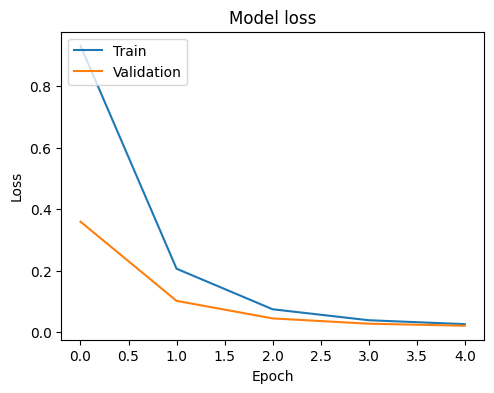

In [80]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [98]:
x_test = "i want to order two medium pizzas with sausage and black olives and two medium pizzas with pepperoni and extra cheese and three large pizzas with pepperoni and sausage"
x_test = clean_text(x_test)
x_test = expnad_abb2(x_test)
x_test = remove_stopwords(x_test)
print(x_test)

two medium sausage and black olives and two medium pepperoni and extra cheese and three large pepperoni and sausage


In [101]:
x_test_relation = input_tokinezer.texts_to_sequences([x_test])
x_test_relation = pad_sequences(x_test_relation, maxlen=max_length, padding='post')
pred_relation = model_relations.predict(x_test_relation)
pred_relation = np.argmax(pred_relation, axis=-1)
pred_relation = [list(relation_tags.keys())[list(relation_tags.values()).index(i)] for i in pred_relation[0]]
print(pred_relation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'O', 'O']


In [102]:
x_test_entity = input_tokinezer_2.texts_to_sequences([x_test])
x_test_entity = pad_sequences(x_test_entity, maxlen=max_len, padding='post')

pred_entity = model.predict(x_test_entity)
pred_entity = np.argmax(pred_entity, axis=-1)
pred_entity = [tags[i] for i in pred_entity[0]]
print(pred_entity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
['B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-TOPPING', 'I-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-NUMBER', 'B-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-TOPPING', 'O', 'O']


In [105]:
import re
from collections import defaultdict

def parse_order(input_text, model1_preds, model2_preds):
    tokens = input_text.split()

    # Combine predictions with tokens
    combined = [
        {"token": token, "model1": m1, "model2": m2}
        for token, m1, m2 in zip(tokens, model1_preds, model2_preds)
    ]

    orders = []
    current_order = None

    for i, item in enumerate(combined):
        token, model1, model2 = item["token"], item["model1"], item["model2"]

        if model1 == "B-Pizza":
            # Start a new order
            # if current_order:
            #     orders.append(current_order)
            if current_order is not None:
                orders.append(current_order)
                
            current_order = {
                "NUMBER": None,
                "SIZE": None,
                "STYLE": None,
                "AllTopping": []
            }
            if model2 == "B-NUMBER":
                current_order["NUMBER"] = token

            if model2 == "B-SIZE":
                current_order["SIZE"] = token
            if model2 == "B-TOPPING":
                topping = {
                    "NOT": False,
                    "Quantity": None,
                    "Topping": token
                }
                current_order["AllTopping"].append(topping)

            if model2 == "B-STYLE":
                current_order["STYLE"] = token
    
        else: 

            if model2 == "B-NUMBER":
                current_order["NUMBER"] = token

            if model2 == "B-SIZE":
                current_order["SIZE"] = token
            if model2 == "B-TOPPING":
                topping = {
                    "NOT": False,
                    "Quantity": None,
                    "Topping": token
                }
                current_order["AllTopping"].append(topping)

            if model2 == "B-STYLE":
                current_order["STYLE"] = token

  

    # Construct final output
    output = {"ORDER": {"PIZZAORDER": orders, "DRINKORDER": []}}
    return output

# Example input
input_text = "two medium sausage and black olives and two medium pepperoni and extra cheese and three large pepperoni and sausage"
model1_preds = ['B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'B-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'I-Pizza', 'O', 'O', 'O']
model2_preds = ['B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-TOPPING', 'I-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-NUMBER', 'B-TOPPING', 'O', 'B-NUMBER', 'B-SIZE', 'B-TOPPING', 'O', 'B-TOPPING', 'O', 'O']

# Parse
output = parse_order(input_text, model1_preds, model2_preds)
output

{'ORDER': {'PIZZAORDER': [{'NUMBER': 'two',
    'SIZE': 'medium',
    'STYLE': None,
    'AllTopping': [{'NOT': False, 'Quantity': None, 'Topping': 'sausage'},
     {'NOT': False, 'Quantity': None, 'Topping': 'black'}]},
   {'NUMBER': 'extra',
    'SIZE': 'medium',
    'STYLE': None,
    'AllTopping': [{'NOT': False, 'Quantity': None, 'Topping': 'pepperoni'},
     {'NOT': False, 'Quantity': None, 'Topping': 'cheese'}]}],
  'DRINKORDER': []}}